### -

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc

from utils import *
from classes import *
from train_models import *

import json
with open('config.json', 'r') as f:
    CONFIG = json.load(f)

/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
color_palette = sns.color_palette("viridis_r", as_cmap=True)
rates_array = np.array(range(0,99,5))*0.01
#comp_thresholds = np.array(range(0,99,25))*0.01

Eles também usaram essa divisão:
- 25% – Geração do pool de classificadores (T): Utilizado para treinar os classificadores base que compõem o pool, garantindo diversidade de modelos para a seleção dinâmica.
- 25% – Meta-treinamento (Tλ): Empregado no treinamento do meta-classificador, responsável por estimar a competência dos classificadores base a partir de meta-features.
- 25% – Seleção dinâmica (DSEL): Usado para definir a região de competência das amostras e apoiar a seleção dinâmica dos classificadores durante a fase de classificação.
- 25% – Conjunto de teste (G): Destinado exclusivamente à avaliação do desempenho final do sistema, sem participação em qualquer etapa de treinamento ou seleção.

---
---
# QSAR

In [3]:
#from train_models import experiment_name
dataset_name = 'qsar'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/298241476481232989', creation_time=1769611763687, experiment_id='298241476481232989', last_update_time=1769611763687, lifecycle_stage='active', name='qsar_v6_1246495320', tags={}>

In [4]:
all_models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
models = all_models['pool_classifiers']
metadesr = all_models['METADESR']
X_T, X_T_lambda, X_DSEL, X_G, y_T, y_T_lambda, y_DSEL, y_G, scaler = get_data(dataset_name)
pred_reject = Pool(models)

Tamanhos dos conjuntos:
  T (Pool): 263 amostras
  T_lambda (Meta-treino): 263 amostras
  DSEL (Seleção dinâmica): 264 amostras
  G (Teste): 265 amostras
73e0a08977244e568f5703176f25e095


e0d1862e91ab4801a2322bf2faf442fb

f3d425299f7e4359b10651ae737d40b3


b3b1b60ac6334a22b132ab39b7b22b05


d4cc1cdfbaad43499992ffe3ac9f5bcb


6e06ce1072814478a3b4d167a6616b2d


e73e543ecaa846e98173fed937d5ea2c


b3614dd347784a5f9516cb9ddf6d84ff


e77a02f8d04e425ca28e0cdb8f52605f


abaedc9deb4d4370abb728f6c7696fdb


a49e0fe9f8eb4dc8ae1df406d7fca2fe


ddf5e1c7d14a4849b22bbf49abbce734


d73ded9d6a7344b396f76e017b42509c


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

Processing: 100%|██████████| 80/80 [00:00<00:00, 101.15it/s, Method=max, Rejection Rate=0.95]  


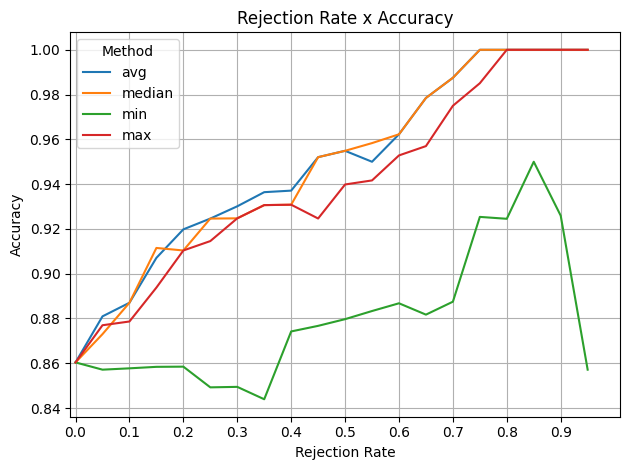

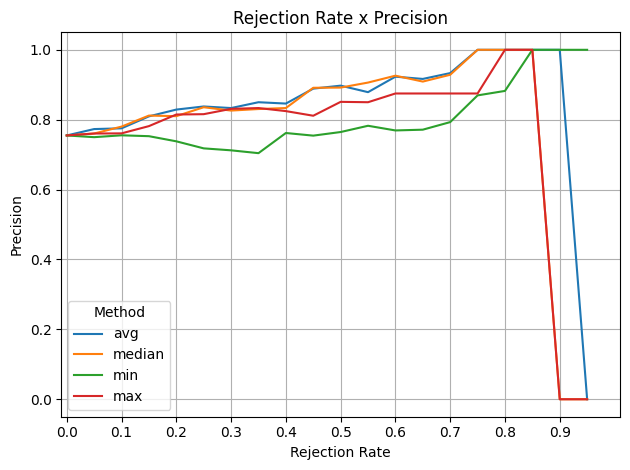

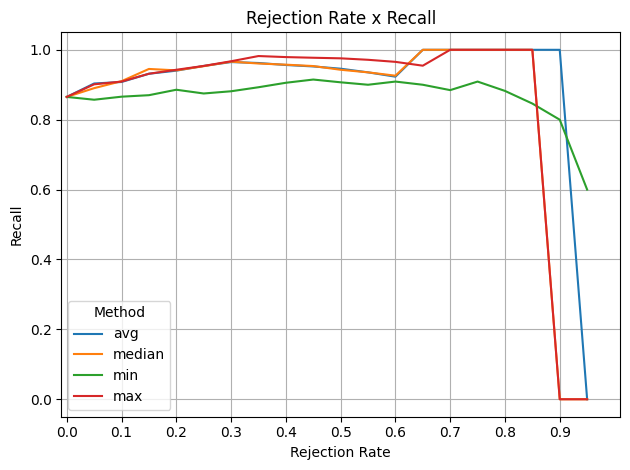

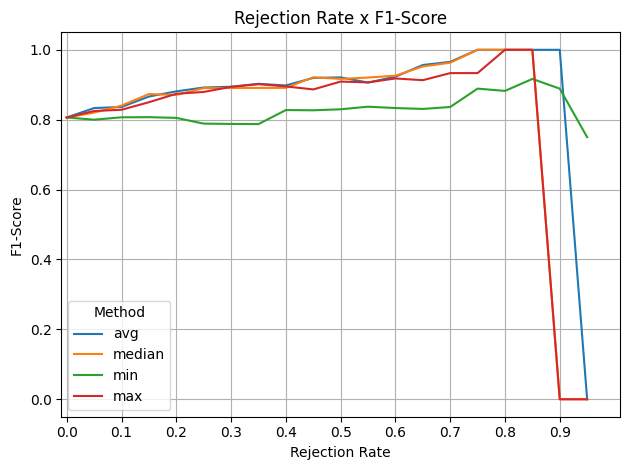

In [5]:
results_log = rejection_overhall(pred_reject, 
                                 X_G,
                                 y_G.values,
                                 rates=rates_array,
                                 methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12}, )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [6]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.902
Method: median 	 |  Score: 0.901
Method: min 	 |  Score: 0.836
Method: max 	 |  Score: 0.893


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.860377,0.754902,0.865169,0.806283,0.901926
1,avg,0.05,0.880952,0.773196,0.903614,0.833333,0.901926
2,avg,0.10,0.887029,0.775281,0.907895,0.836364,0.901926
3,avg,0.15,0.907080,0.809524,0.931507,0.866242,0.901926
4,avg,0.20,0.919811,0.828947,0.940299,0.881119,0.901926
...,...,...,...,...,...,...,...
75,max,0.75,0.985075,0.875000,1.000000,0.933333,0.893342
76,max,0.80,1.000000,1.000000,1.000000,1.000000,0.893342
77,max,0.85,1.000000,1.000000,1.000000,1.000000,0.893342
78,max,0.90,1.000000,0.000000,0.000000,0.000000,0.893342


In [7]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

Processing: 100%|██████████| 80/80 [00:10<00:00,  7.83it/s, Method=max, Rejection Rate=0.95]   


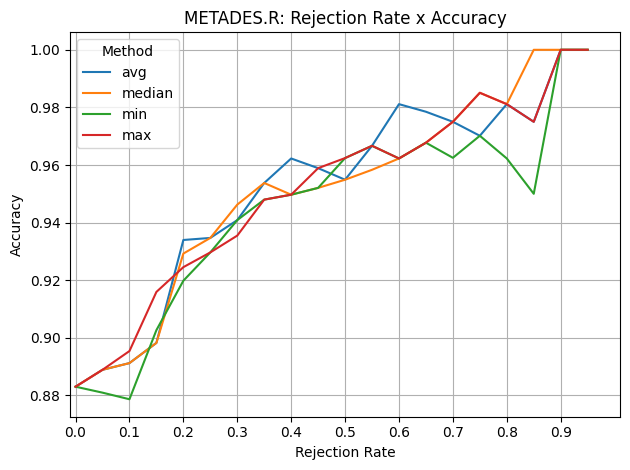

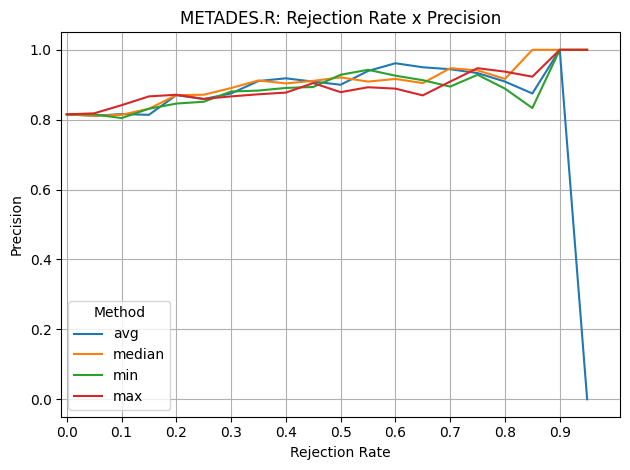

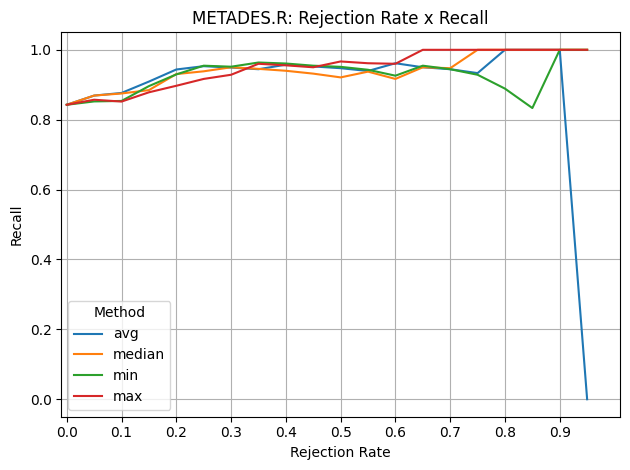

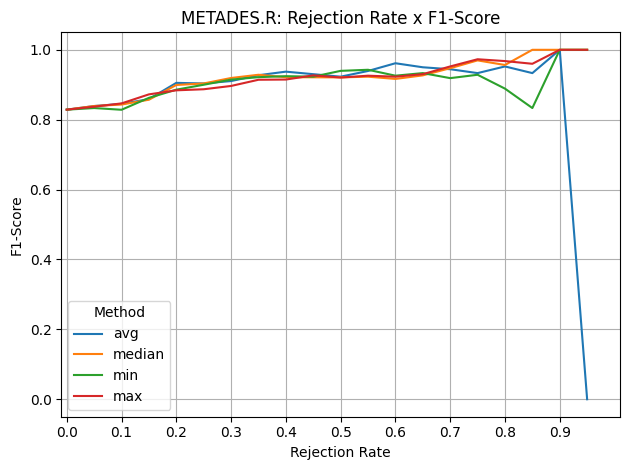

In [8]:
results_log_metadesr = rejection_overhall(metadesr, X_G, y_G, 
                                          rates=rates_array,
                                          methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'METADES.R: Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log_metadesr, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12})
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [9]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log_metadesr.loc[results_log_metadesr['Method']==method, 'Accuracy'])
    results_log_metadesr.loc[results_log_metadesr['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log_metadesr

Method: avg 	 |  Score: 0.904
Method: median 	 |  Score: 0.903
Method: min 	 |  Score: 0.897
Method: max 	 |  Score: 0.903


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.883019,0.815217,0.842697,0.828729,0.904336
1,avg,0.05,0.888889,0.811111,0.869048,0.839080,0.904336
2,avg,0.10,0.891213,0.816092,0.876543,0.845238,0.904336
3,avg,0.15,0.898230,0.813953,0.909091,0.858896,0.904336
4,avg,0.20,0.933962,0.870130,0.943662,0.905405,0.904336
...,...,...,...,...,...,...,...
75,max,0.75,0.985075,0.947368,1.000000,0.972973,0.903162
76,max,0.80,0.981132,0.937500,1.000000,0.967742,0.903162
77,max,0.85,0.975000,0.923077,1.000000,0.960000,0.903162
78,max,0.90,1.000000,1.000000,1.000000,1.000000,0.903162


In [ ]:
results_log_metadesr.to_csv(f'results/{dataset_name}_metadesr_{CONFIG["VERSION"]}.csv')

---
---
# ADULT

In [11]:
#from train_models import experiment_name
dataset_name = 'adult'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/570384305152607692', creation_time=1769611783764, experiment_id='570384305152607692', last_update_time=1769611783764, lifecycle_stage='active', name='adult_v6_1246495320', tags={}>

In [12]:
all_models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
models = all_models['pool_classifiers']
metadesr = all_models['METADESR']
X_T, X_T_lambda, X_DSEL, X_G, y_T, y_T_lambda, y_DSEL, y_G, scaler = get_data(dataset_name)
pred_reject = Pool(models)

Tamanhos dos conjuntos:
  T (Pool): 7540 amostras
  T_lambda (Meta-treino): 7539 amostras
  DSEL (Seleção dinâmica): 7541 amostras
  G (Teste): 7542 amostras
041d9dc8aaa34641b12fc3df998c07c5


047fe8bc2313446ca097ff1b0af9738f


a879f8c6ebb84b60a3c7499cc9855bdc


dd3d8a4a58d84a6392b7f162ef6f8def


10ce4e39cbdb4b02acd77ee65fbf29e6


9563df550b0b4e798c45b2a98f64ff9e


a25ba1633e4844ea975080ffc11d3a7e


48032586a61d43fcb75c8b7548b0ac28


35fbec7aebc6408babab80ef66410419


94081eb1dfc640a58833aaf187f9d3f1


932c2247424c4c8488c7bef3e2d95a5d


f872637bf6b9490393d4d8e59cb059ca


5612ad8548984fefa4fa911e118b172b


Processing: 100%|██████████| 80/80 [00:02<00:00, 27.63it/s, Method=max, Rejection Rate=0.95]   


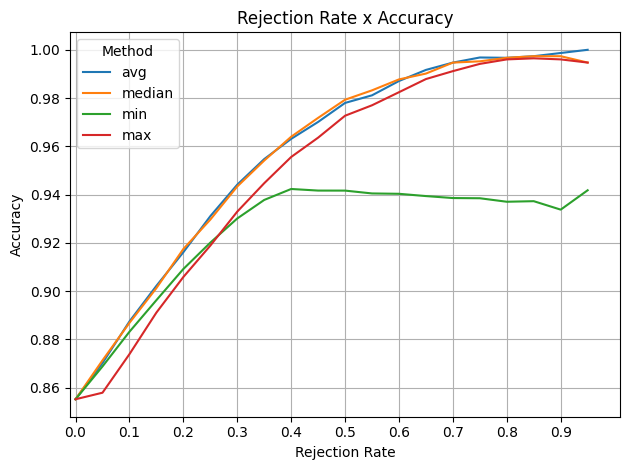

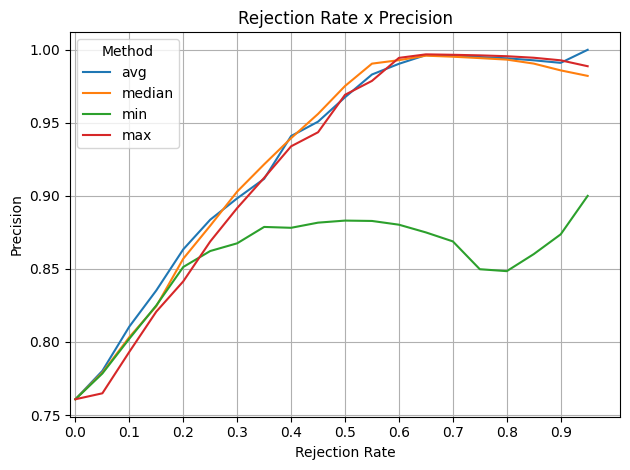

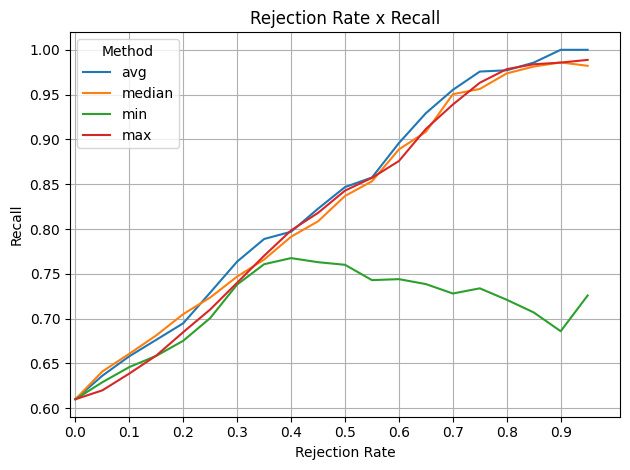

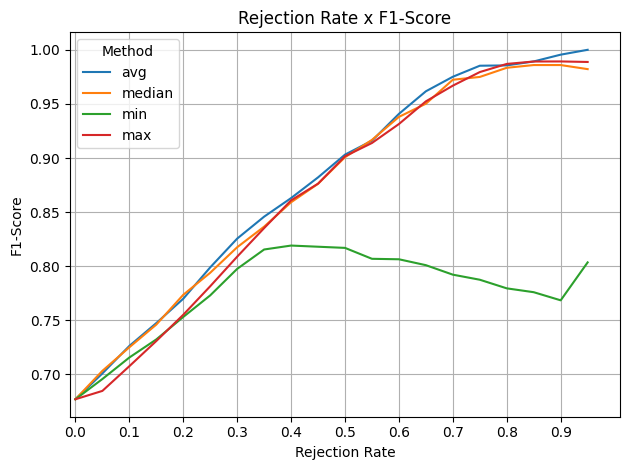

In [13]:
results_log = rejection_overhall(pred_reject, 
                                 X_G,
                                 y_G.values,
                                 rates=rates_array,
                                 methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12})
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [14]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.909
Method: median 	 |  Score: 0.909
Method: min 	 |  Score: 0.879
Method: max 	 |  Score: 0.903


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.855211,0.760797,0.610016,0.677114,0.909441
1,avg,0.05,0.870202,0.780243,0.636311,0.700965,0.909441
2,avg,0.10,0.887448,0.810552,0.658014,0.726361,0.909441
3,avg,0.15,0.902199,0.835284,0.676385,0.747483,0.909441
4,avg,0.20,0.916142,0.863405,0.694832,0.770000,0.909441
...,...,...,...,...,...,...,...
75,max,0.75,0.994168,0.996198,0.963235,0.979439,0.903168
76,max,0.80,0.996024,0.995614,0.978448,0.986957,0.903168
77,max,0.85,0.996466,0.994565,0.983871,0.989189,0.903168
78,max,0.90,0.996026,0.992806,0.985714,0.989247,0.903168


In [15]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

Processing: 100%|██████████| 80/80 [02:52<00:00,  2.15s/it, Method=max, Rejection Rate=0.95]   


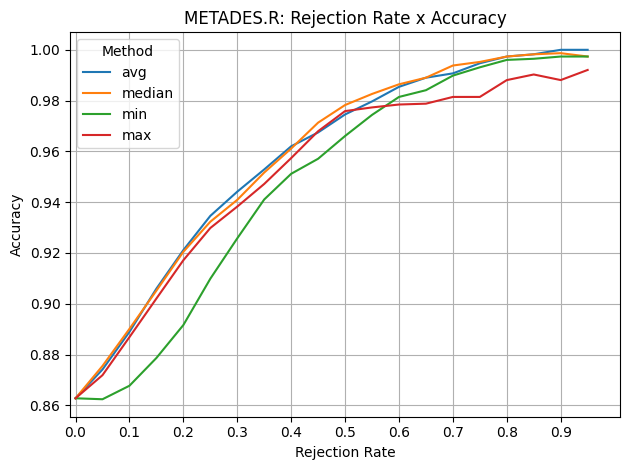

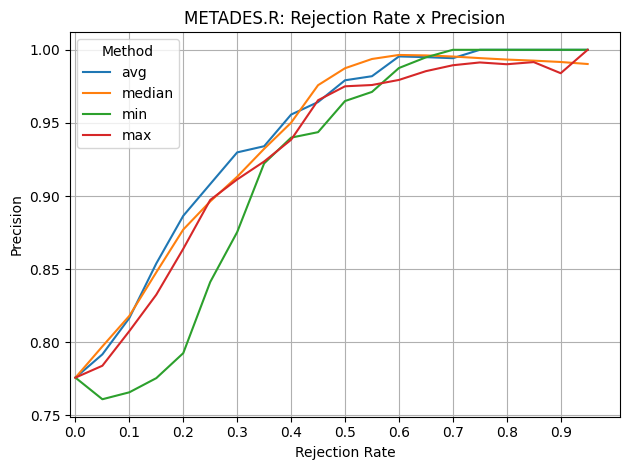

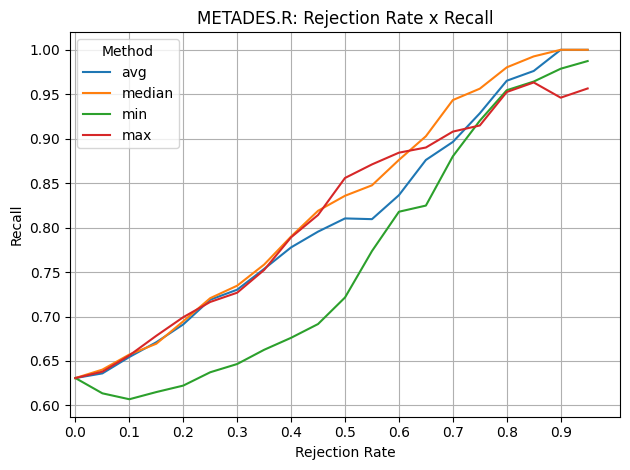

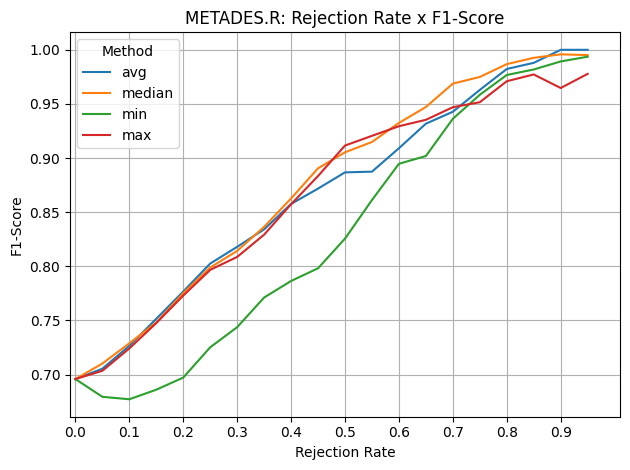

In [16]:
results_log_metadesr = rejection_overhall(metadesr, X_G, y_G, 
                                          rates=rates_array,
                                          methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'METADES.R: Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log_metadesr, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12})
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [17]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log_metadesr.loc[results_log_metadesr['Method']==method, 'Accuracy'])
    results_log_metadesr.loc[results_log_metadesr['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log_metadesr

Method: avg 	 |  Score: 0.910
Method: median 	 |  Score: 0.910
Method: min 	 |  Score: 0.900
Method: max 	 |  Score: 0.904


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.862768,0.775885,0.630794,0.695857,0.909609
1,avg,0.05,0.874110,0.791789,0.636042,0.705421,0.909609
2,avg,0.10,0.888922,0.816626,0.654474,0.726613,0.909609
3,avg,0.15,0.905943,0.853933,0.671082,0.751545,0.909609
4,avg,0.20,0.921114,0.886510,0.691152,0.776735,0.909609
...,...,...,...,...,...,...,...
75,max,0.75,0.981442,0.991354,0.914894,0.951591,0.904281
76,max,0.80,0.988072,0.990132,0.952532,0.970968,0.904281
77,max,0.85,0.990283,0.991597,0.963265,0.977226,0.904281
78,max,0.90,0.988079,0.984000,0.946154,0.964706,0.904281


In [18]:
results_log_metadesr.to_csv(f'results/{dataset_name}_metadesr_{CONFIG["VERSION"]}.csv')

---
---
# MAGIC GAMMA

In [19]:
#from train_models import experiment_name
dataset_name = 'magic_gamma'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/709846682725768599', creation_time=1769611814255, experiment_id='709846682725768599', last_update_time=1769611814255, lifecycle_stage='active', name='magicgamma_v6_1246495320', tags={}>

In [20]:
all_models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
models = all_models['pool_classifiers']
metadesr = all_models['METADESR']
X_T, X_T_lambda, X_DSEL, X_G, y_T, y_T_lambda, y_DSEL, y_G, scaler = get_data(dataset_name)
pred_reject = Pool(models)

Tamanhos dos conjuntos:
  T (Pool): 4755 amostras
  T_lambda (Meta-treino): 4754 amostras
  DSEL (Seleção dinâmica): 4755 amostras
  G (Teste): 4756 amostras
f678ef72039341dea9c193df8fafd5f3


9751191f3c3e4979b7b8856b265c229f


3c008141854047ec870923774f07696a


78efbcf4405241abb29b9c2c1a5dedfc


31acdfc96ac947739de50efb2ffb2292


b63c8ee085394bf5b434b801fc5edf94


acad12bfaddb4aed977eac7cb2969d6b


f2ff41c7f65a4fa39ca53bec710cc4e2


e1d1e6e1b5ff473db8f9a3e260f78870


5d5c15c806bd4d8ca68a0a73a5661eb9


96ae89a4679847a38f12982902bc1267


a0fe3ebd4851461d9a6a3cb243a5bb84


df0557c8f8294a96a218325b402c5af8


Processing: 100%|██████████| 80/80 [00:01<00:00, 46.14it/s, Method=max, Rejection Rate=0.95]   


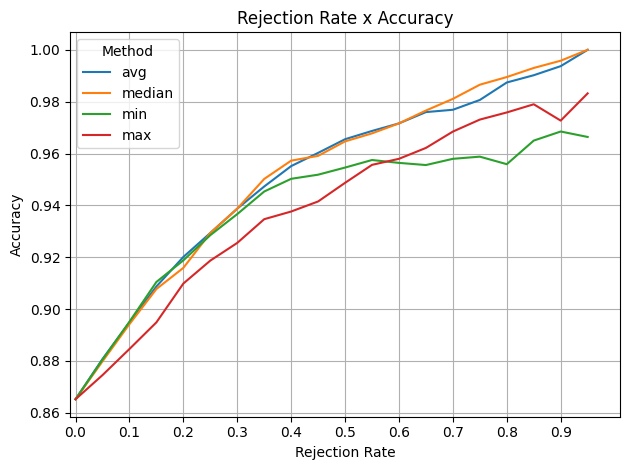

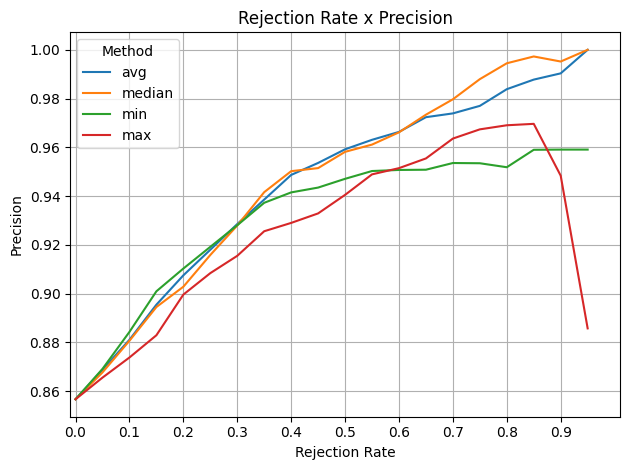

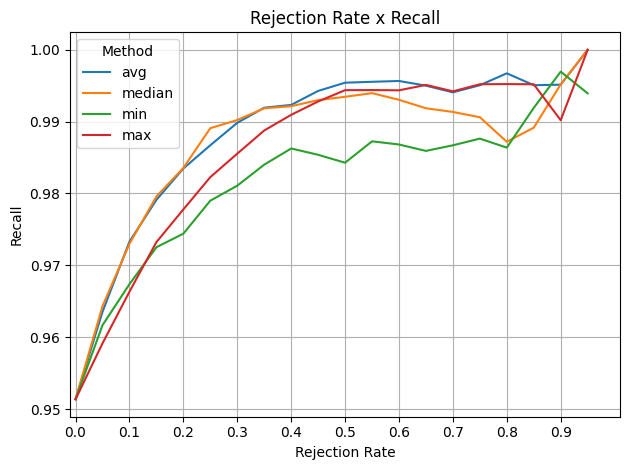

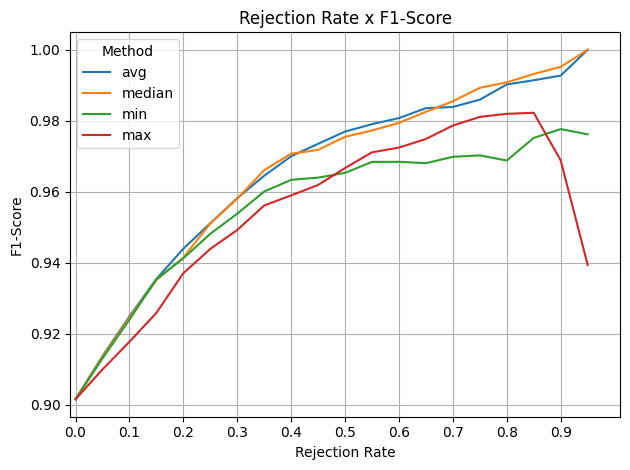

In [21]:
results_log = rejection_overhall(pred_reject, 
                                 X_G,
                                 y_G.values,
                                 rates=rates_array,
                                 methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12}, )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [22]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.904
Method: median 	 |  Score: 0.905
Method: min 	 |  Score: 0.893
Method: max 	 |  Score: 0.892


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.865223,0.856642,0.951362,0.901521,0.903923
1,avg,0.05,0.880726,0.868758,0.963526,0.913691,0.903923
2,avg,0.10,0.894884,0.881043,0.973296,0.924875,0.903923
3,avg,0.15,0.908731,0.895442,0.979113,0.935410,0.903923
4,avg,0.20,0.920105,0.907480,0.983481,0.943953,0.903923
...,...,...,...,...,...,...,...
75,max,0.75,0.973087,0.967366,0.995204,0.981087,0.891982
76,max,0.80,0.975840,0.969040,0.995231,0.981961,0.891982
77,max,0.85,0.978992,0.969626,0.995204,0.982249,0.891982
78,max,0.90,0.972689,0.948357,0.990196,0.968825,0.891982


In [23]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

Processing: 100%|██████████| 80/80 [03:24<00:00,  2.56s/it, Method=max, Rejection Rate=0.95]   


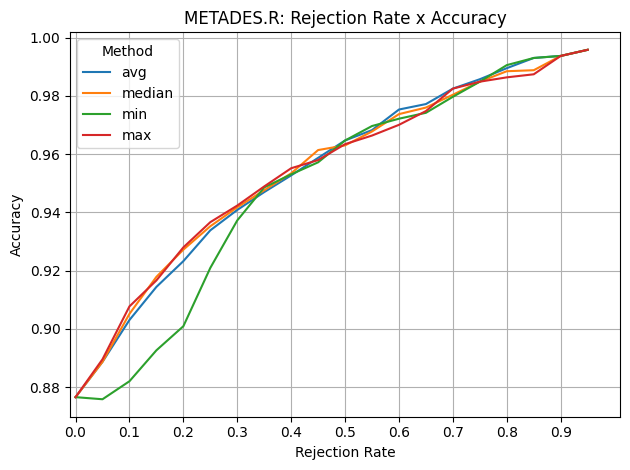

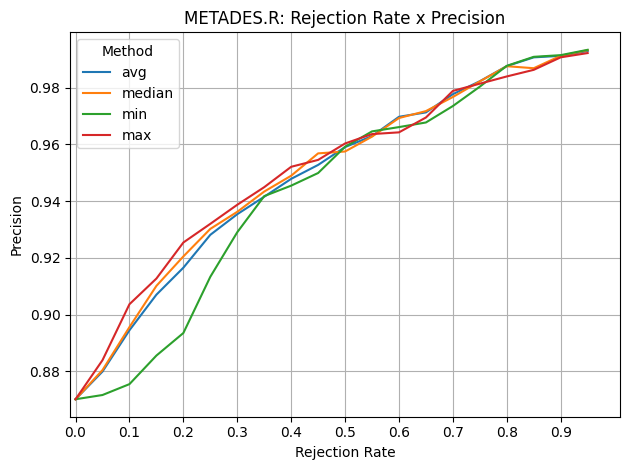

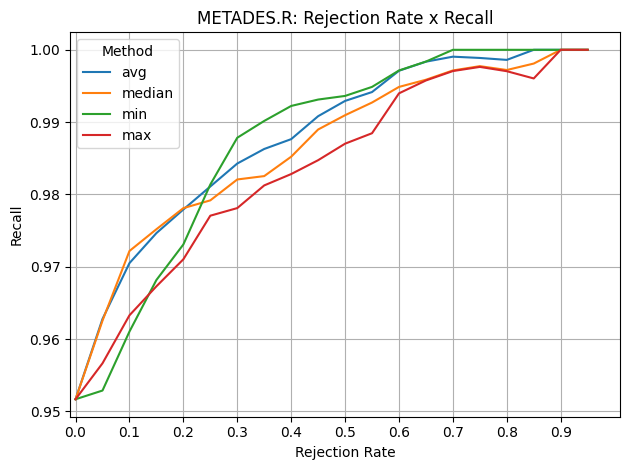

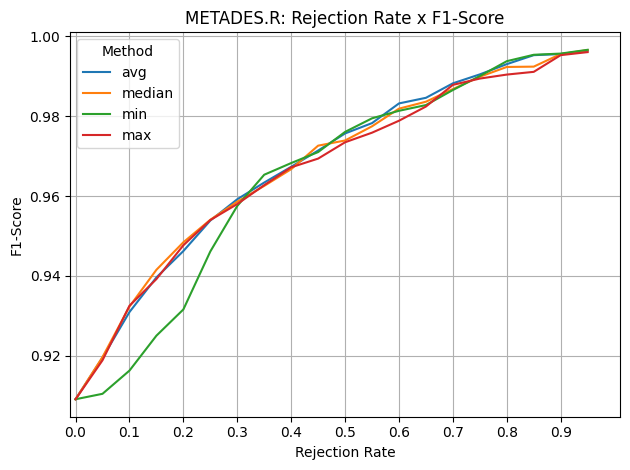

In [24]:
results_log_metadesr = rejection_overhall(metadesr, X_G, y_G, 
                                          rates=rates_array,
                                          methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'METADES.R: Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log_metadesr, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12})
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [25]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log_metadesr.loc[results_log_metadesr['Method']==method, 'Accuracy'])
    results_log_metadesr.loc[results_log_metadesr['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log_metadesr

Method: avg 	 |  Score: 0.906
Method: median 	 |  Score: 0.907
Method: min 	 |  Score: 0.901
Method: max 	 |  Score: 0.906


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.876577,0.870145,0.951686,0.909091,0.906422
1,avg,0.05,0.888692,0.879902,0.962789,0.919481,0.906422
2,avg,0.10,0.903060,0.894468,0.970507,0.930937,0.906422
3,avg,0.15,0.914420,0.907008,0.974656,0.939616,0.906422
4,avg,0.20,0.923259,0.916518,0.977922,0.946225,0.906422
...,...,...,...,...,...,...,...
75,max,0.75,0.984861,0.981395,0.997636,0.989449,0.906425
76,max,0.80,0.986345,0.983942,0.997041,0.990448,0.906425
77,max,0.85,0.987395,0.986275,0.996040,0.991133,0.906425
78,max,0.90,0.993697,0.990683,1.000000,0.995320,0.906425


In [26]:
results_log_metadesr.to_csv(f'results/{dataset_name}_metadesr_{CONFIG["VERSION"]}.csv')

---
---
# CREDIT

In [27]:
#from train_models import experiment_name
dataset_name = 'credit'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/231064499481371914', creation_time=1769611841590, experiment_id='231064499481371914', last_update_time=1769611841590, lifecycle_stage='active', name='credit_v6_1246495320', tags={}>

In [28]:
all_models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
models = all_models['pool_classifiers']
metadesr = all_models['METADESR']
X_T, X_T_lambda, X_DSEL, X_G, y_T, y_T_lambda, y_DSEL, y_G, scaler = get_data(dataset_name)
pred_reject = Pool(models)

Tamanhos dos conjuntos:
  T (Pool): 11682 amostras
  T_lambda (Meta-treino): 7499 amostras
  DSEL (Seleção dinâmica): 7500 amostras
  G (Teste): 7501 amostras
c5f725be47e74a69ae7b3cdc932d3314


f1e4add1259142168c8df3db6cd353ed


84f89aab7af54041b0b5aa2e6a0d3794


49d17607624147ec99f16f4419b4e8ee


d0590459520b481b85d9a0616b8bb879


dbe8d045180e4d679e053078b4331b0d


750ff88569f6484db6837bc62df359b1


fb924a14573b41819c58db78eca90317


0c0ff7093f9e461fa76deb29f5a0c6b1


c2a6f7a630be44209ee25660888765f5


58cc2c05a8a74a6f86977673ae4f744a


d7bc188d20cf45e491e426a392357181


e41474cbe7fd4d54b48c6cb6a3e52394


Processing: 100%|██████████| 80/80 [00:04<00:00, 16.57it/s, Method=max, Rejection Rate=0.95]   


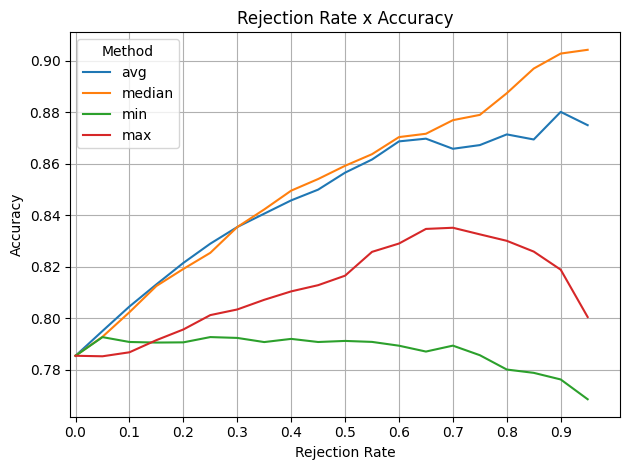

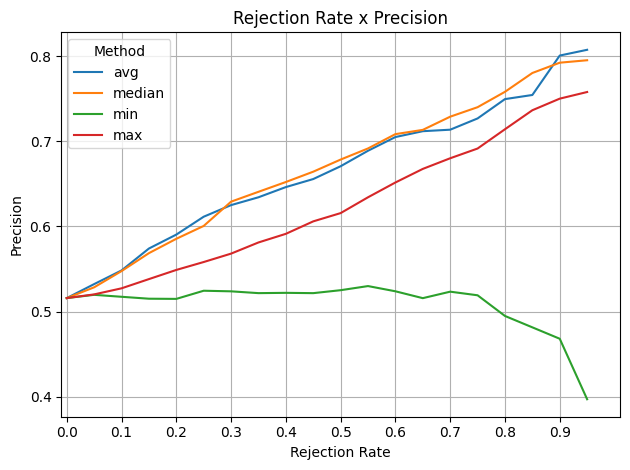

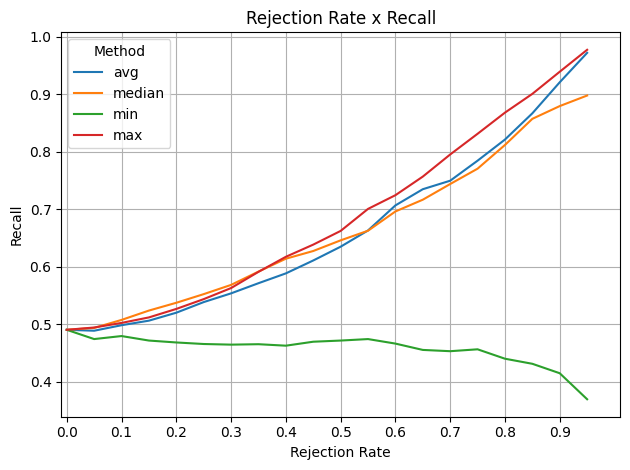

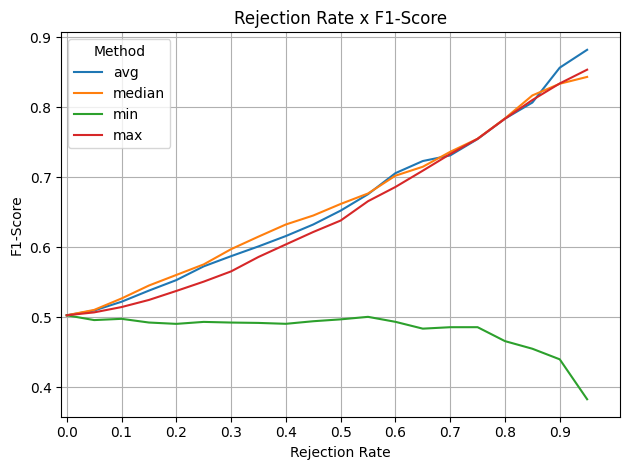

In [29]:
results_log = rejection_overhall(pred_reject, 
                                 X_G,
                                 y_G.values,
                                 rates=rates_array,
                                 methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12}, )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [30]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.804
Method: median 	 |  Score: 0.809
Method: min 	 |  Score: 0.748
Method: max 	 |  Score: 0.772


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.785495,0.515843,0.490657,0.502935,0.803824
1,avg,0.05,0.795116,0.532258,0.489046,0.509738,0.803824
2,avg,0.10,0.804622,0.548289,0.498617,0.522275,0.803824
3,avg,0.15,0.813206,0.574028,0.506569,0.538193,0.803824
4,avg,0.20,0.821530,0.590383,0.520408,0.553191,0.803824
...,...,...,...,...,...,...,...
75,max,0.75,0.832623,0.691429,0.831615,0.755070,0.771836
76,max,0.80,0.830113,0.714065,0.868421,0.783715,0.771836
77,max,0.85,0.825933,0.736380,0.901075,0.810445,0.771836
78,max,0.90,0.818908,0.750000,0.939560,0.834146,0.771836


In [31]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

Processing: 100%|██████████| 80/80 [08:47<00:00,  6.60s/it, Method=max, Rejection Rate=0.95]   


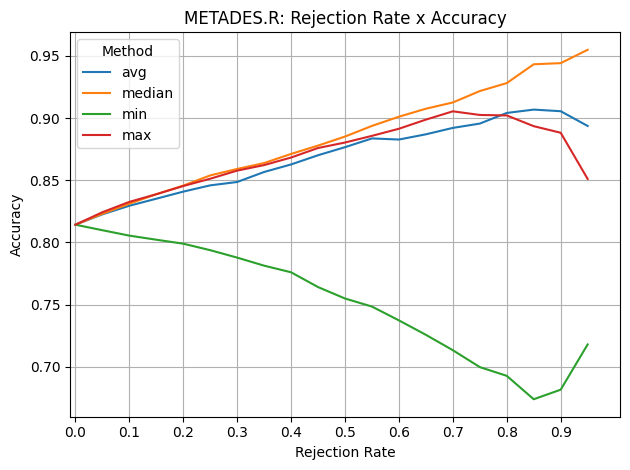

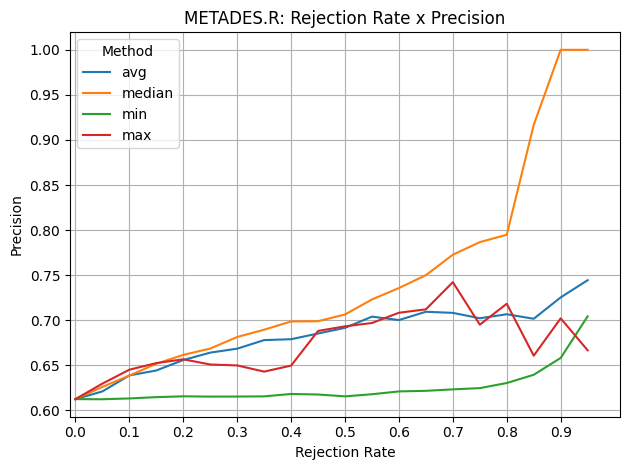

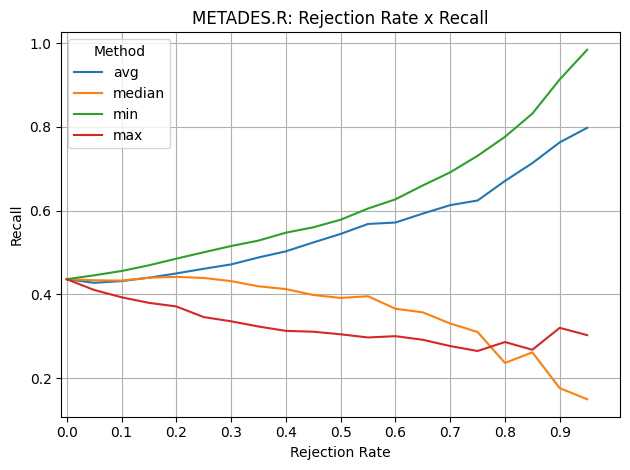

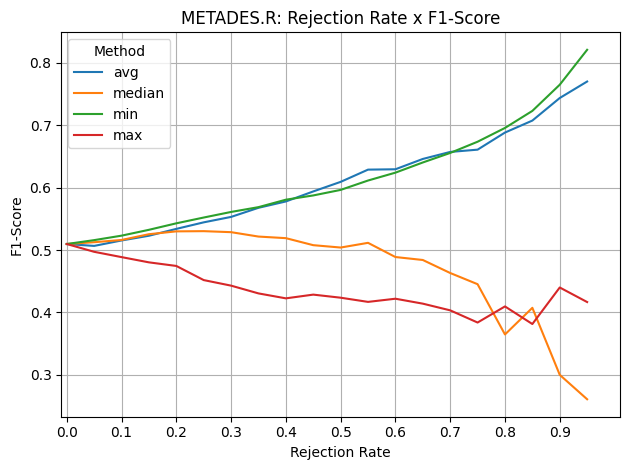

In [32]:
results_log_metadesr = rejection_overhall(metadesr, X_G, y_G, 
                                          rates=rates_array,
                                          methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'METADES.R: Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log_metadesr, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12})
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [33]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log_metadesr.loc[results_log_metadesr['Method']==method, 'Accuracy'])
    results_log_metadesr.loc[results_log_metadesr['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log_metadesr

Method: avg 	 |  Score: 0.825
Method: median 	 |  Score: 0.839
Method: min 	 |  Score: 0.716
Method: max 	 |  Score: 0.827


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.814291,0.612521,0.436407,0.509680,0.824982
1,avg,0.05,0.822621,0.621053,0.427818,0.506635,0.824982
2,avg,0.10,0.829507,0.638831,0.431898,0.515368,0.824982
3,avg,0.15,0.835163,0.644295,0.440031,0.522923,0.824982
4,avg,0.20,0.840860,0.655875,0.450206,0.533919,0.824982
...,...,...,...,...,...,...,...
75,max,0.75,0.902452,0.695122,0.265116,0.383838,0.826827
76,max,0.80,0.902065,0.718310,0.286517,0.409639,0.826827
77,max,0.85,0.893428,0.660714,0.268116,0.381443,0.826827
78,max,0.90,0.888149,0.702128,0.320388,0.440000,0.826827


In [34]:
results_log_metadesr.to_csv(f'results/{dataset_name}_metadesr_{CONFIG["VERSION"]}.csv')

---
---
# MARKETING

In [35]:
#from train_models import experiment_name
dataset_name = 'marketing'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/918192882679793311', creation_time=1769611880389, experiment_id='918192882679793311', last_update_time=1769611880389, lifecycle_stage='active', name='marketing_v6_1246495320', tags={}>

In [36]:
all_models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
models = all_models['pool_classifiers']
metadesr = all_models['METADESR']
X_T, X_T_lambda, X_DSEL, X_G, y_T, y_T_lambda, y_DSEL, y_G, scaler = get_data(dataset_name)
pred_reject = Pool(models)

Tamanhos dos conjuntos:
  T (Pool): 18274 amostras
  T_lambda (Meta-treino): 10295 amostras
  DSEL (Seleção dinâmica): 10298 amostras
  G (Teste): 10298 amostras
374fa4f325e64614b7751f806be50970


930291746c3842ba804788fa65f93ce8


1bafcb9b44404ce2ad8c9e61e3afbad4


d1d08074e7304ec28c5fabd09eec15f1


71b87380859e4846b00409c7be8a82ec


41a2fa98f25b4124b24f309fda845d98


6d9c49edf2d74774a598177225476b6a


70d899f3a0124a659cce4a1ac8b723e6


7d91fe0844d0417db90998daecce2c06


1fc649a1e3db4f05a53fca2e16c51dac


5da1871e367b4ee495ae9ed5559e049f


6a6b4d3f55624d4683e104e39f51966a


368d867a95094a1f9cf57ecc55a11505


Processing: 100%|██████████| 80/80 [00:05<00:00, 15.31it/s, Method=max, Rejection Rate=0.95]   


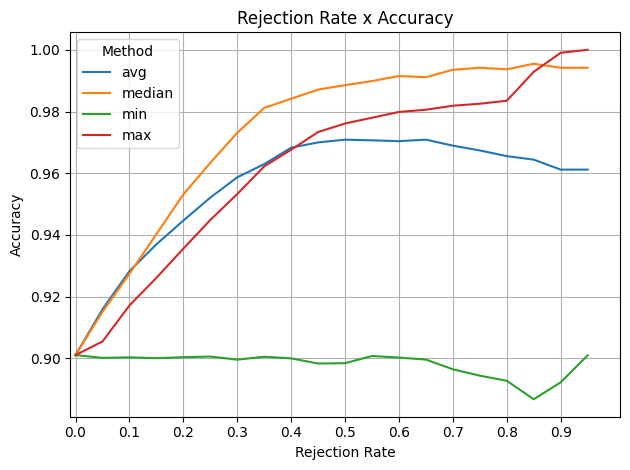

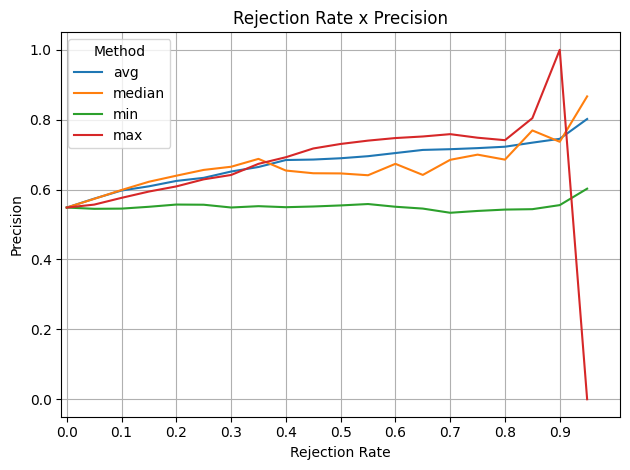

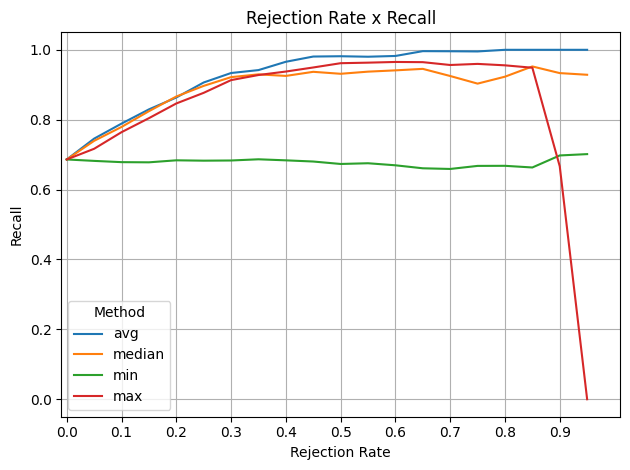

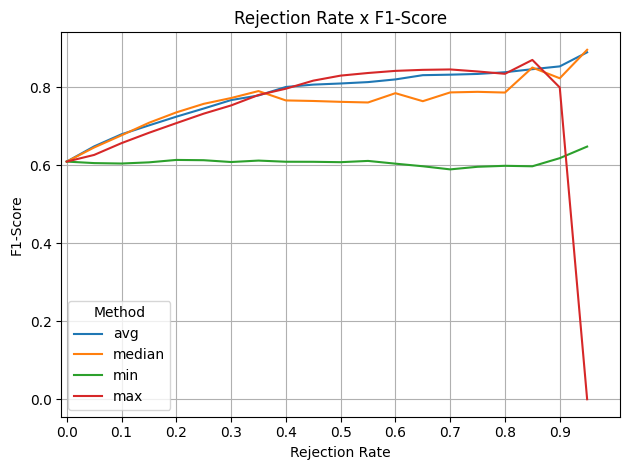

In [37]:
results_log = rejection_overhall(pred_reject, 
                                 X_G,
                                 y_G.values,
                                 rates=rates_array,
                                 methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12}, )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.857
Method: median 	 |  Score: 0.874
Method: min 	 |  Score: 0.806
Method: max 	 |  Score: 0.862


,Method,Rejection Rate,Rejection Threshold,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.0,0.00,0.897844,0.608434,0.261207,0.365501,0.857204
1,avg,0.0,0.25,0.899592,0.541944,0.701724,0.611570,0.857204
2,avg,0.0,0.50,0.897650,0.533974,0.718103,0.612500,0.857204
3,avg,0.0,0.75,0.897650,0.533974,0.718103,0.612500,0.857204
4,avg,0.1,0.00,0.918546,0.663551,0.317318,0.429327,0.857204
...,...,...,...,...,...,...,...,...
155,max,0.8,0.75,0.983495,0.741379,0.955556,0.834951,0.861826
156,max,0.9,0.00,0.997087,0.000000,0.000000,0.000000,0.861826
157,max,0.9,0.25,0.999029,1.000000,0.666667,0.800000,0.861826
158,max,0.9,0.50,0.999029,1.000000,0.666667,0.800000,0.861826


In [39]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

Processing: 100%|██████████| 80/80 [06:04<00:00,  4.55s/it, Method=max, Rejection Rate=0.95]   


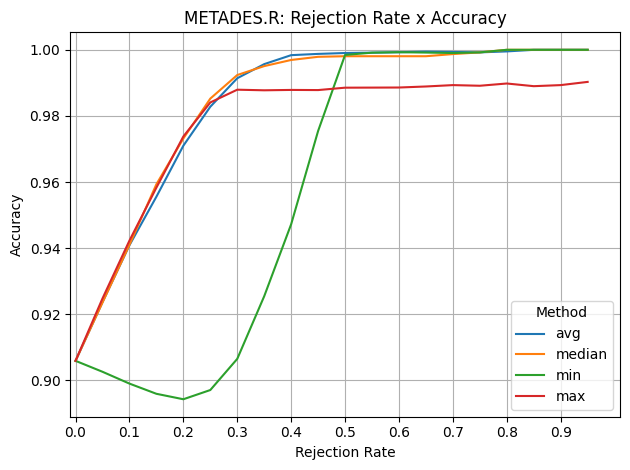

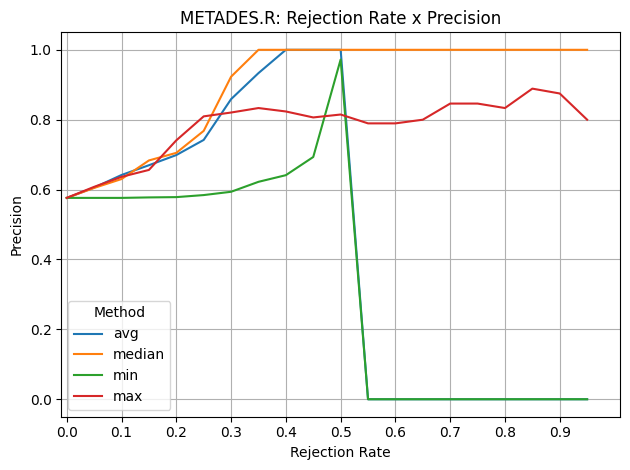

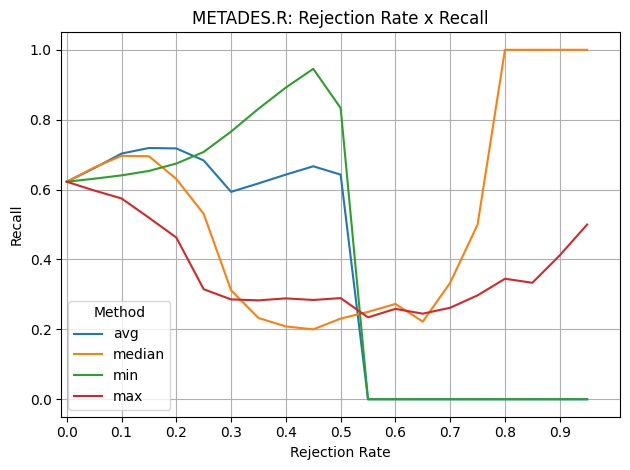

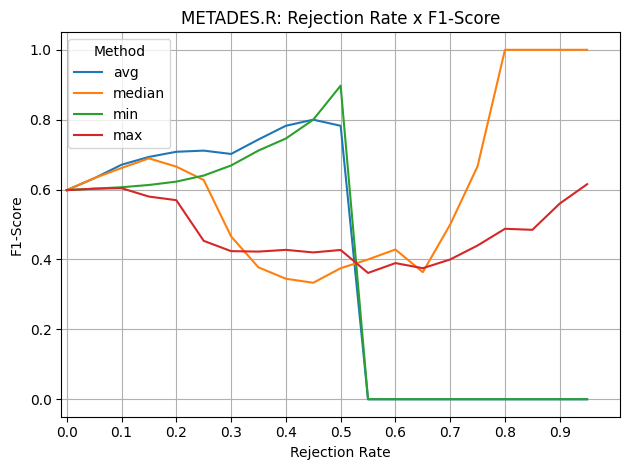

In [38]:
results_log_metadesr = rejection_overhall(metadesr, X_G, y_G, 
                                          rates=rates_array, 
                                          methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'METADES.R: Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log_metadesr, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12})
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [40]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log_metadesr.loc[results_log_metadesr['Method']==method, 'Accuracy'])
    results_log_metadesr.loc[results_log_metadesr['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log_metadesr

Method: avg 	 |  Score: 0.935
Method: median 	 |  Score: 0.935
Method: min 	 |  Score: 0.910
Method: max 	 |  Score: 0.929


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.905904,0.576217,0.622414,0.598425,0.935300
1,avg,0.05,0.923651,0.605660,0.661174,0.632201,0.935300
2,avg,0.10,0.940878,0.641791,0.703145,0.671068,0.935300
3,avg,0.15,0.955563,0.669711,0.718954,0.693459,0.935300
4,avg,0.20,0.970992,0.698795,0.717822,0.708181,0.935300
...,...,...,...,...,...,...,...
75,max,0.75,0.989126,0.846154,0.297297,0.440000,0.929193
76,max,0.80,0.989806,0.833333,0.344828,0.487805,0.929193
77,max,0.85,0.988997,0.888889,0.333333,0.484848,0.929193
78,max,0.90,0.989320,0.875000,0.411765,0.560000,0.929193


In [41]:
results_log_metadesr.to_csv(f'results/{dataset_name}_metadesr_{CONFIG["VERSION"]}.csv')

---
---
# DRIVE

In [42]:
#from train_models import experiment_name
dataset_name = 'drive'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/331244612952559037', creation_time=1769611923423, experiment_id='331244612952559037', last_update_time=1769611923423, lifecycle_stage='active', name='drive_v6_1246495320', tags={}>

In [43]:
all_models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
models = all_models['pool_classifiers']
metadesr = all_models['METADESR']
X_T, X_T_lambda, X_DSEL, X_G, y_T, y_T_lambda, y_DSEL, y_G, scaler = get_data(dataset_name)
pred_reject = Pool(models)

Tamanhos dos conjuntos:
  T (Pool): 14627 amostras
  T_lambda (Meta-treino): 14625 amostras
  DSEL (Seleção dinâmica): 14628 amostras
  G (Teste): 14629 amostras
08c9ef14e59548a880f983793b3f22c9


b6a6571a9e5d4e119b6a8797b43f0690


61bb07dd8b4846e7a842f12a92a8d013


7491d9dd53f441e6b9d2f981dd11e4fe


ee877b0cab944c4e81e80593bdca6435


c6efa47aeefa4101884c6e9a77f084e7


7076ef26704048f4bacdfba29f654fda


633e528453f4400caf9440efdeeffd26


db4415bfaeba4e84a2882e54115ce669


7e232327c7c84111ac77f3e41320c37c


15c065858f9542e7938d1f67713b9d95


f4eb642857414223a5010110973e884f


781acd9b547f486abd0c61def5f0ca6c


Processing: 100%|██████████| 80/80 [00:12<00:00,  6.38it/s, Method=max, Rejection Rate=0.95]   


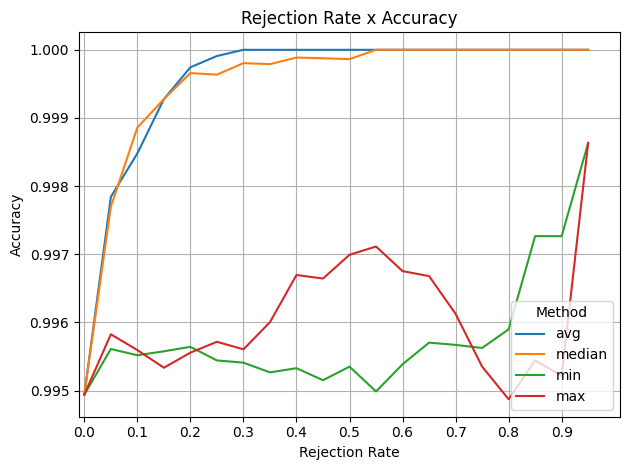

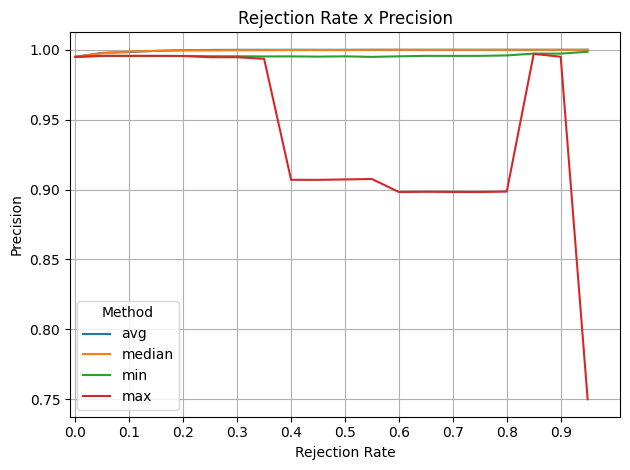

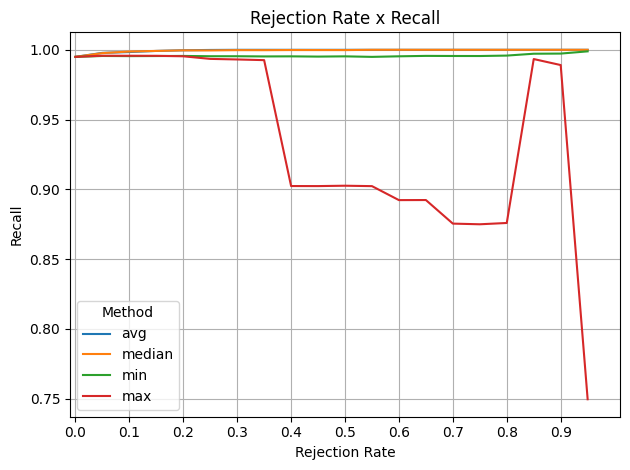

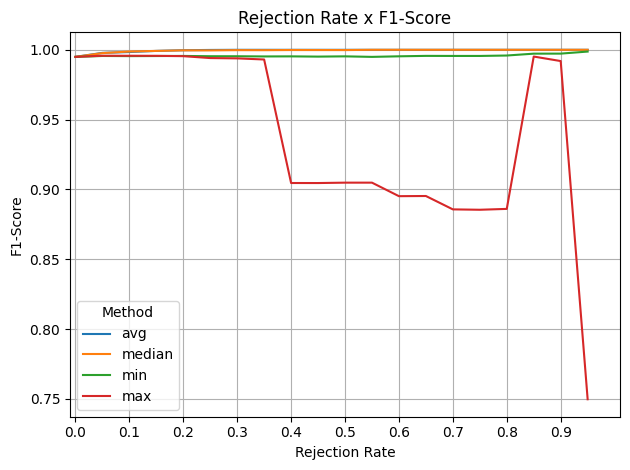

In [44]:
results_log = rejection_overhall(pred_reject, 
                                 X_G,
                                 y_G.values,
                                 rates=rates_array,
                                 methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12}, )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [45]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.950
Method: median 	 |  Score: 0.950
Method: min 	 |  Score: 0.946
Method: max 	 |  Score: 0.946


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.994942,0.994945,0.994942,0.994941,0.949636
1,avg,0.05,0.997841,0.997809,0.997807,0.997807,0.949636
2,avg,0.10,0.998481,0.998415,0.998395,0.998405,0.949636
3,avg,0.15,0.999276,0.999234,0.999192,0.999213,0.949636
4,avg,0.20,0.999744,0.999744,0.999685,0.999714,0.949636
...,...,...,...,...,...,...,...
75,max,0.75,0.995353,0.898244,0.874993,0.885482,0.946216
76,max,0.80,0.994874,0.898570,0.875930,0.886103,0.946216
77,max,0.85,0.995444,0.997094,0.993376,0.995170,0.946216
78,max,0.90,0.995215,0.995038,0.989076,0.991944,0.946216


In [46]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

Processing: 100%|██████████| 80/80 [13:26<00:00, 10.08s/it, Method=max, Rejection Rate=0.95]   


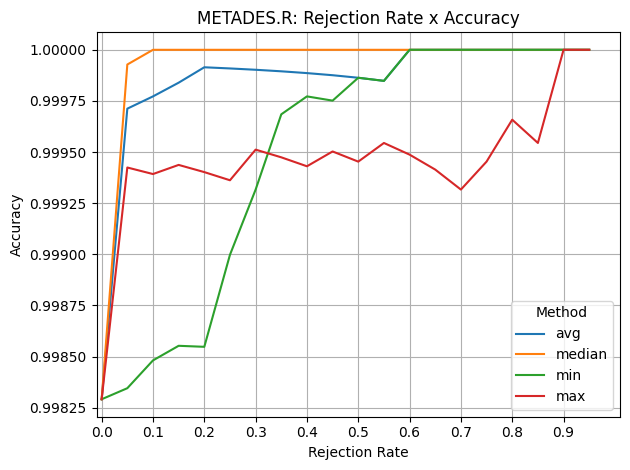

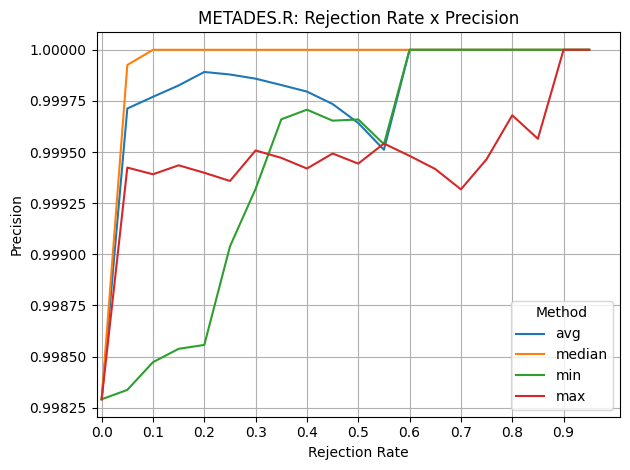

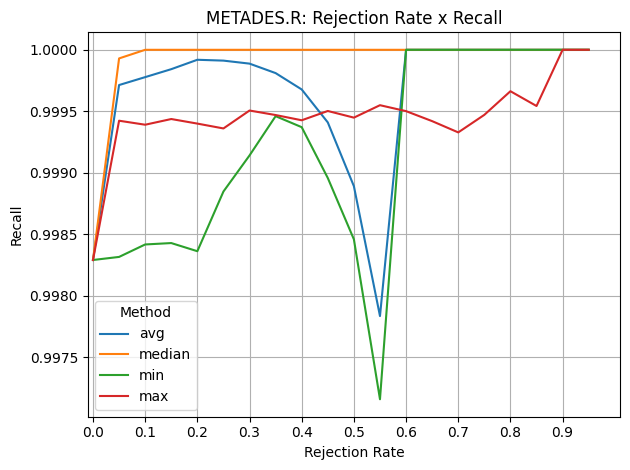

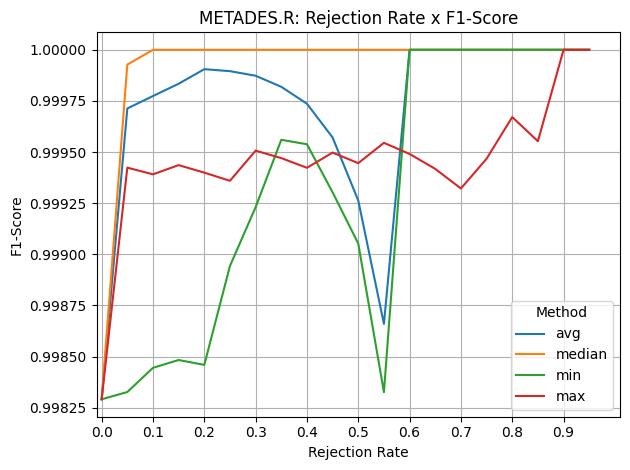

In [47]:
results_log_metadesr = rejection_overhall(metadesr, X_G, y_G, 
                                          rates=rates_array,
                                          methods=['avg','median','min','max'])

xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'METADES.R: Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log_metadesr, x='Rejection Rate', y=metric, hue='Method', linewidth=1.5, err_kws={'alpha':0.12})
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [48]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log_metadesr.loc[results_log_metadesr['Method']==method, 'Accuracy'])
    results_log_metadesr.loc[results_log_metadesr['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log_metadesr

Method: avg 	 |  Score: 0.950
Method: median 	 |  Score: 0.950
Method: min 	 |  Score: 0.950
Method: max 	 |  Score: 0.949


,Method,Rejection Rate,Accuracy,Precision,Recall,F1-Score,AU-ARC
0,avg,0.00,0.998291,0.998292,0.998291,0.998291,0.949878
1,avg,0.05,0.999712,0.999713,0.999713,0.999713,0.949878
2,avg,0.10,0.999772,0.999770,0.999778,0.999774,0.949878
3,avg,0.15,0.999839,0.999826,0.999843,0.999834,0.949878
4,avg,0.20,0.999915,0.999892,0.999919,0.999905,0.949878
...,...,...,...,...,...,...,...
75,max,0.75,0.999453,0.999465,0.999471,0.999467,0.949498
76,max,0.80,0.999658,0.999680,0.999663,0.999671,0.949498
77,max,0.85,0.999544,0.999565,0.999543,0.999553,0.949498
78,max,0.90,1.000000,1.000000,1.000000,1.000000,0.949498


In [49]:
results_log_metadesr.to_csv(f'results/{dataset_name}_metadesr_{CONFIG["VERSION"]}.csv')